## SP95 protocol simulation

![](GasStation-base-borrowing-flow.png)

**This Jupyter Notebook showcases an analysis of the SP95 protocol and the financial risk to users under various market conditions.**  
We simulate a distribution of 10,000 users opening troves at the beginning of a 1-year simulation period with various collateral sizes and collateralization ratios.  
  
Each day, a new gasETH value is computed using Ethereum historical gas data. Based on this value, we report the number of liquidable troves then allow troves to top-up or withdraw collateral in their trove.  
  
The goal of the simulation is to find good parameters for the protocol in order to maximize capital efficiency and minimize liquidation risks. The two parameters are the minimum collateralization ratio (impact on capital efficiency) and the window size (impact on liquidation risk).

## 1. Initialization

### Import of the various libraries

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Simulation parameters

In [81]:
protocol_min_ratio = 3
Number_of_users = 10000
rolling_window = 7
mean_top_up_frequency = 7

### Import the historical base fee data (source : https://etherscan.io/chart/gasprice)

For simulation we use the etherscan gasprice data, it is a time series of daily average gas price denominated in Wei. We truncate the data to retain a one-year simulation period.  
In order to smooth out the values, we use a moving average, one of the goals of the simulation is to determine the impact of the size of the moving window on the number of liquidable troves.

In [82]:
historical_base_fee = (pd.read_csv("AvgGasPrice.csv",index_col="Date(UTC)")["Value (Wei)"]*(10**-9)).rolling(rolling_window).mean()
base_fee_extract = historical_base_fee[-366:]

### Protocol logic implementation

Each trove is defined by a collateral amount (in ETH), a debt amount (in gasETH), an initial collateralization ratio (used to model users' risk profile) and an inattention parameter (used to model a "top-up" behaviour)

In [83]:
class trove :
    def __init__(self,_collateral,_debt,_initial_ratio,_inattention_parameter):
        self.collateral = _collateral
        self.debt = _debt 
        self.initial_ratio = _initial_ratio
        self.inattention_parameter = _inattention_parameter

    def collateral_ratio(self,base_fee):
        return self.collateral/(self.debt*(10**(-3))*base_fee)

Each modelled user can open a trove and top-up some collateral, we monitor the protocol risk using its total collateralization ratio (TCR)

In [84]:
class gasProtocol :

    def __init__(self,min_ratio):
        self.troves = {}
        self.min_ratio = min_ratio
        self.max_ID = 0
    
    def open_trove(self,_collateral,_debt,_initial_ratio,_inattention_parameter,base_fee):
        collateral_ratio = _collateral/(_debt*(10**(-3))*base_fee)

        if collateral_ratio < self.min_ratio :
            print("Collateral_ratio is too low")
        else :
            self.troves[self.max_ID] = trove(_collateral,_debt,_initial_ratio,_inattention_parameter)
            self.max_ID += 1

    def add_collateral(self,_amount,_trove_id):
        self.troves[_trove_id].collateral += _amount

    def check_for_liquidations(self,base_fee):
        troves_to_liquidate = []

        for key,trove in self.troves.items():
            if trove.collateral_ratio(base_fee) <= self.min_ratio :
                troves_to_liquidate.append(key)
        return troves_to_liquidate

    def total_collateral(self):
        total_collateral = 0
        for key,trove in self.troves.items() :
            total_collateral += trove.collateral
        return total_collateral

    def total_collateral_ratio(self,base_fee):
        total_collateral = 0
        total_debt = 0

        for key,trove in self.troves.items():
            total_collateral = total_collateral + trove.collateral
            total_debt = total_debt + trove.debt

        return total_collateral/(total_debt*(10**(-3))*base_fee)

## 2. Simulation

## Users initialization

### Initial base fee definition

In [85]:
initial_base_fee = base_fee_extract[0]

### Draw of users' parameters

Explanation of parameters : ///

In [86]:
Users_collateral = np.random.uniform(1,100,Number_of_users) # Distribution uniforme pour le collatéral
Users_ratio = np.random.exponential(0.5,Number_of_users) + 1.5*protocol_min_ratio
Users_debt = Users_collateral/(Users_ratio*(10**(-3))*initial_base_fee)
Users_inattention_parameter = np.random.gamma(25,0.02,Number_of_users)

### Plot of the various distributions

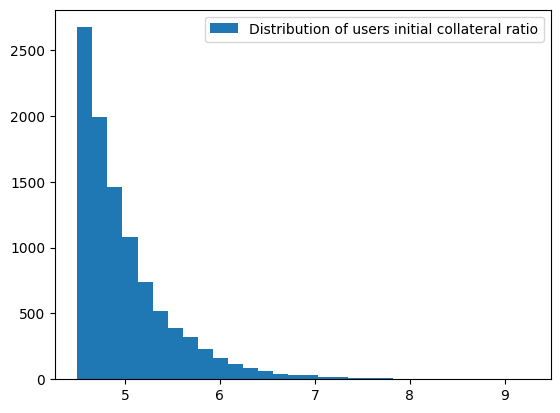

In [87]:
plt.hist(Users_ratio,label="Distribution of users initial collateral ratio",bins=30)
plt.legend()
plt.show()

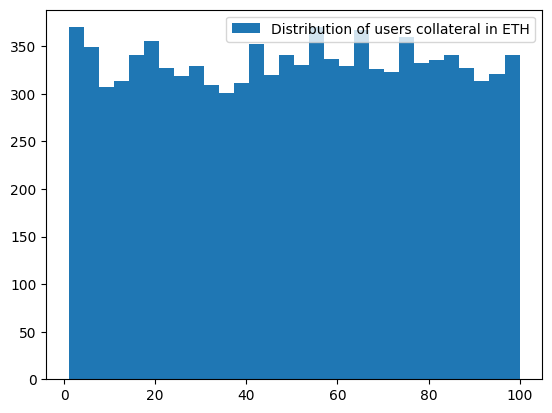

In [88]:
plt.hist(Users_collateral,label="Distribution of users collateral in ETH",bins=30)
plt.legend()
plt.show()

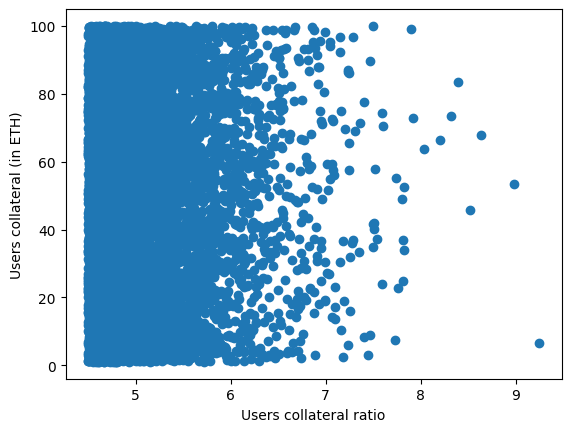

In [89]:
plt.scatter(Users_ratio,Users_collateral)
plt.xlabel("Users collateral ratio")
plt.ylabel("Users collateral (in ETH)")
plt.show()

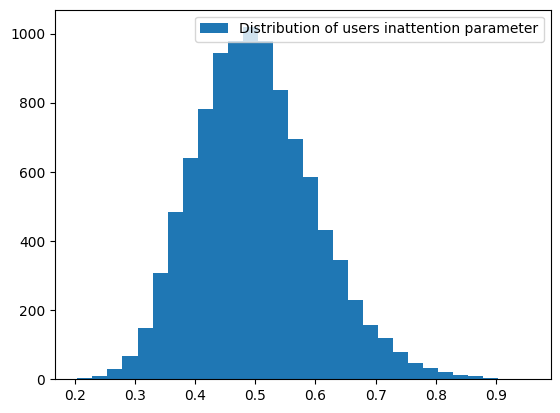

In [90]:
plt.hist(Users_inattention_parameter,label="Distribution of users inattention parameter",bins=30)
plt.legend()
plt.show()

## Simulation program

In [91]:
""" Simulation routine """

time_period = len(base_fee_extract) - 1
protocol_TCR = []
liquidation_count = []
total_collateral = []
protocol = gasProtocol(protocol_min_ratio)

""" Troves initiation """

for i in range(Number_of_users):
    protocol.open_trove(Users_collateral[i],Users_debt[i],Users_ratio[i],Users_inattention_parameter[i],initial_base_fee)

protocol_TCR.append(protocol.total_collateral_ratio(initial_base_fee))
""" Time period simulation """

for j in range(time_period):
    """ Update the base fee """
    base_fee = base_fee_extract[j+1]

    """ Check for liquidations """
    liquidable_troves = protocol.check_for_liquidations(base_fee)

    """ Top-ups """
    for key,trove in protocol.troves.items() :
        if mean_top_up_frequency == 0 :
            pass
        else :
            random_number = np.random.uniform(0,1)
            if random_number <= 1/mean_top_up_frequency :
                if (trove.collateral_ratio(base_fee)>= trove.initial_ratio - trove.inattention_parameter) and (trove.collateral_ratio(base_fee)<=trove.initial_ratio + trove.inattention_parameter) :
                    pass
                else :
                    amount = trove.initial_ratio*trove.debt*base_fee*(10**(-3)) - trove.collateral
                    protocol.add_collateral(amount,key)
    
    protocol_TCR.append(protocol.total_collateral_ratio(base_fee))
    liquidation_count.append(len(liquidable_troves))
    total_collateral.append(protocol.total_collateral())


## Simulation results

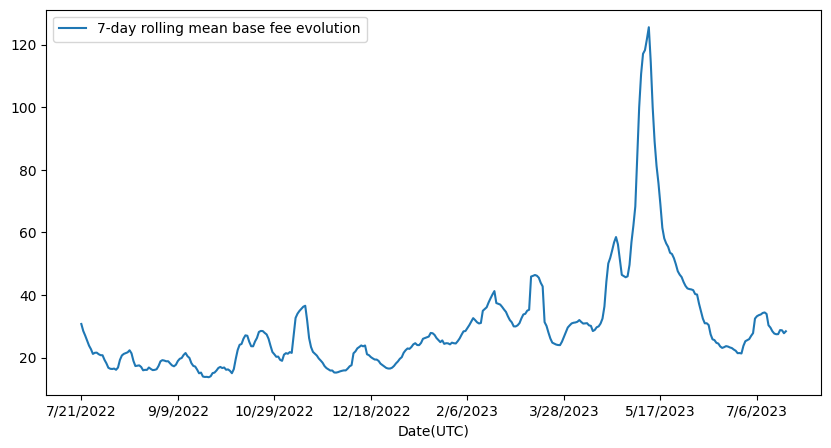

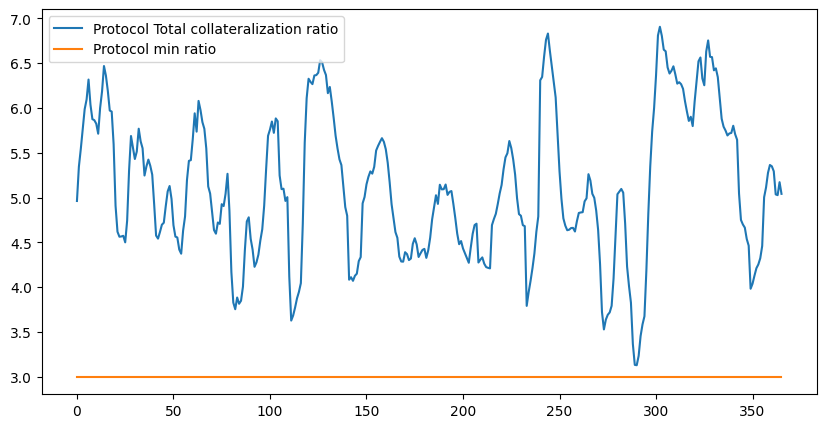

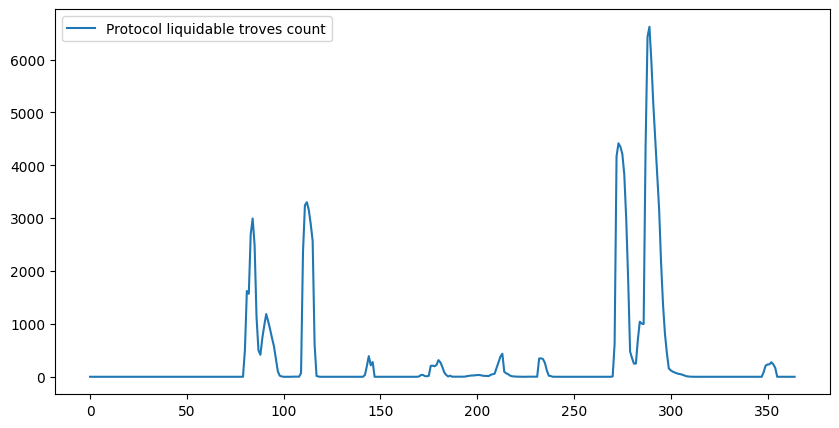

In [92]:
fig1 = plt.figure(1,figsize=(10,5))
base_fee_extract.plot(label= str(rolling_window) + "-day rolling mean base fee evolution")
plt.legend()
plt.show()
fig2 = plt.figure(2,figsize=(10,5))
plt.plot(protocol_TCR,label="Protocol Total collateralization ratio")
plt.plot(np.ones(len(protocol_TCR))*protocol_min_ratio,label="Protocol min ratio")
plt.legend()
plt.show()
fig3 = plt.figure(3,figsize=(10,5))
plt.plot(liquidation_count,label="Protocol liquidable troves count")
plt.legend()
plt.show()